In [1]:
from utils import BiLSTM_CRF
from utils import evaluate, get_embedding_matrix, CustomDataset
import pickle as pkl
import torch
import os
import gensim
import json
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [2]:
def get_emb(embedding):
    if embedding == "word2vec":
        model = "Embeddings/GoogleNews-vectors-negative300.bin.gz"
        embedding_model = gensim.models.KeyedVectors.load_word2vec_format(model, binary=True)
    elif embedding == "glove":
        model = "Embeddings/glove.42B.300d.bin.gz"
        embedding_model = gensim.models.KeyedVectors.load_word2vec_format(model, binary=True)
    else:
        model = "Embeddings/cc.en.300.bin.gz"
        embedding_model = gensim.models.fasttext.load_facebook_model(model).wv
    return embedding_model

In [3]:
def load_model(task: int, emb_model,emb_name: str):
    filename = f"CRF_Models/t{task}_bilstm-crf_{emb_name}.pt"
    emb_matrix = get_embedding_matrix(emb_model)
    model = BiLSTM_CRF(input_size = 300, hidden_size = 128, output_size = 27 if task == 1 else 3,
                        embedding_matrix = emb_matrix, num_layers = 2)
    model.load_state_dict(torch.load(filename))
    model.eval()
    return model

def get_label_encoder(task: int):
    dataset = 'ATE' if task == 2 else 'NER'
    filename = f'Datasets/preprocessed/{dataset}/{dataset}_train.json'
    json_file = json.load(open(filename))
    labels = set()
    for data in json_file.values():
        labels.update(data["labels"])
    encoder = LabelEncoder()
    encoder.fit(sorted(labels))
    return encoder

def get_data(task: int,emb_name):
    dataset = 'ATE' if task == 2 else 'NER'
    filename = f'Datasets/preprocessed/{dataset}/{dataset}_test.json'
    json_file = json.load(open(filename))
    data = [],[]
    for entry in json_file.values():
        data[0].append(entry["text"].split())
        data[1].append(entry["labels"])
    dataset = CustomDataset(data[0], data[1],get_label_encoder(task),get_emb(emb_name))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
    return dataloader,dataset

def bar(labelwise_f1_scores):
    sorted_labels, sorted_scores = zip(*sorted(labelwise_f1_scores.items(), key=lambda x: x[1], reverse=True))
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_labels, sorted_scores, color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('F1 Score')
    plt.title('Label-wise F1 Scores')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


Task 1 - Word2vec

Accuracy: 0.96450, Precision: 0.56653, Recall: 0.57339, F1-Score: 0.55928


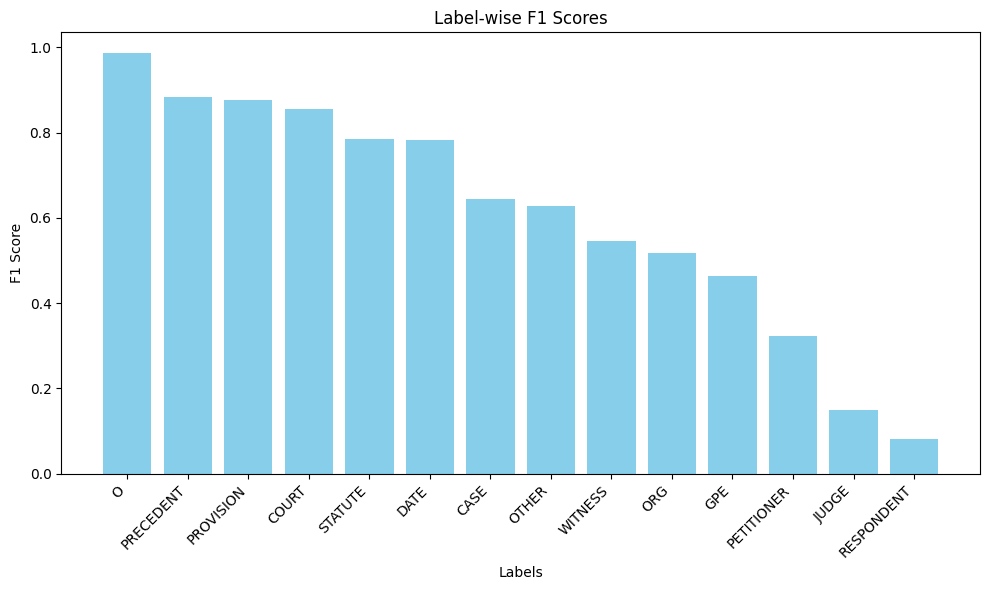

In [4]:
test_loader, test_set = get_data(1,'word2vec')
model = load_model(1,test_set.embedding,'word2vec')
results = evaluate(model, test_loader, model.loss, CRF=True)
bar(results['class_wise_f1:'])

Task 1 - GlOve

Accuracy: 0.94859, Precision: 0.41854, Recall: 0.44258, F1-Score: 0.42016


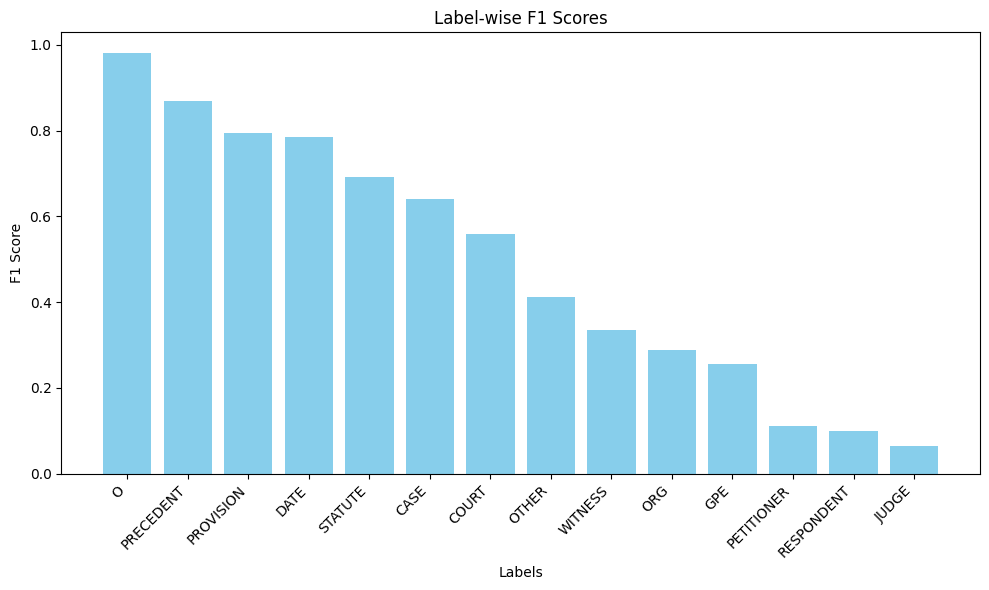

In [6]:
test_loader, test_set = get_data(1,'glove')
model = load_model(1,test_set.embedding,'glove')
results = evaluate(model, test_loader, model.loss, CRF=True)
bar(results['class_wise_f1:'])

Task 1 - FastText

Accuracy: 0.97131, Precision: 0.62984, Recall: 0.63512, F1-Score: 0.62816


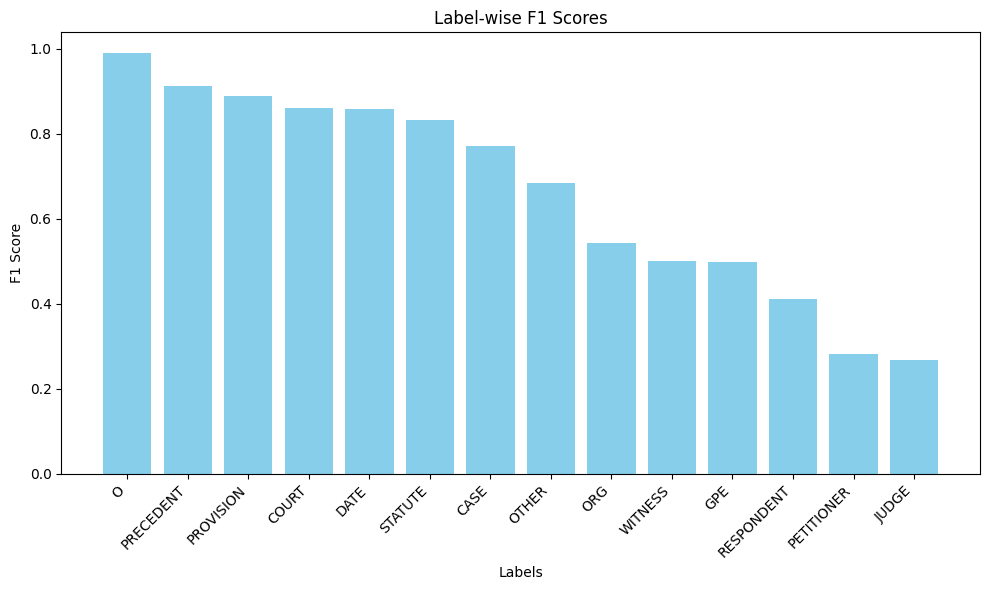

In [8]:
test_loader, test_set = get_data(1,'fasttext')
model = load_model(1,test_set.embedding,'fasttext')
results = evaluate(model, test_loader, model.loss, CRF=True)
bar(results['class_wise_f1:'])

Task 2 - Word2vec

Accuracy: 0.98403, Precision: 0.86801, Recall: 0.69144, F1-Score: 0.75979


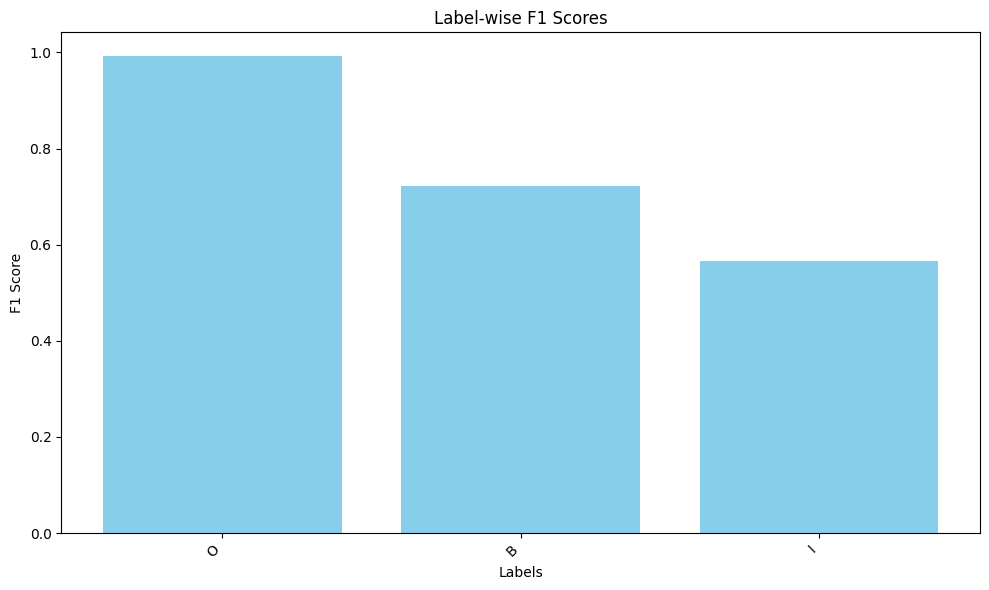

In [10]:
test_loader, test_set = get_data(2,'word2vec')
model = load_model(2,test_set.embedding,'word2vec')
results = evaluate(model, test_loader, model.loss, CRF=True)
bar(results['class_wise_f1:'])

Task 2 - GlOve

Accuracy: 0.98068, Precision: 0.75450, Recall: 0.75753, F1-Score: 0.75507


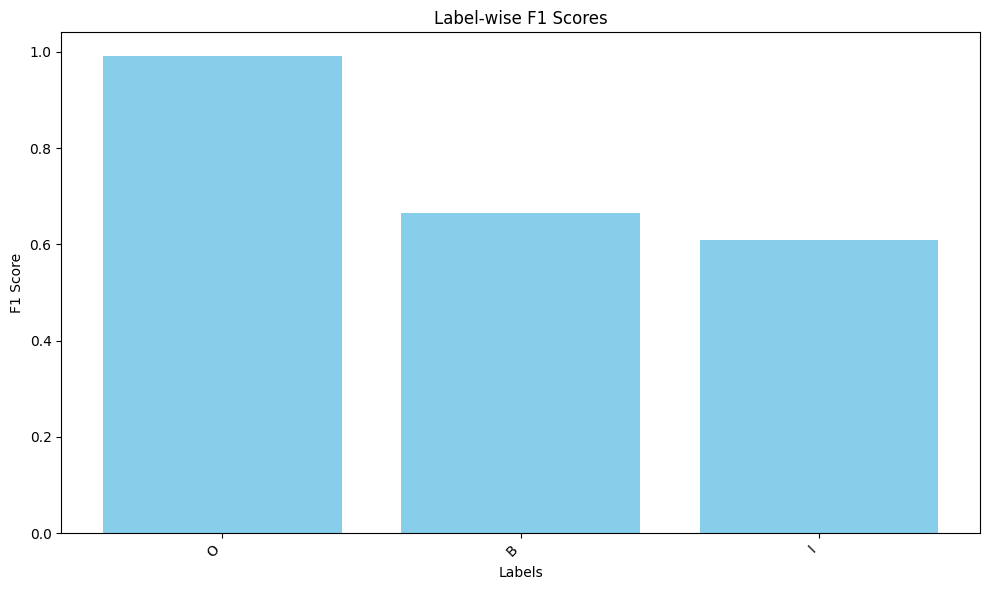

In [12]:
test_loader, test_set = get_data(2,'glove')
model = load_model(2,test_set.embedding,'glove')
results = evaluate(model, test_loader, model.loss, CRF=True)
bar(results['class_wise_f1:'])

Task 2 - FastText

Accuracy: 0.98042, Precision: 0.74200, Recall: 0.84333, F1-Score: 0.78622


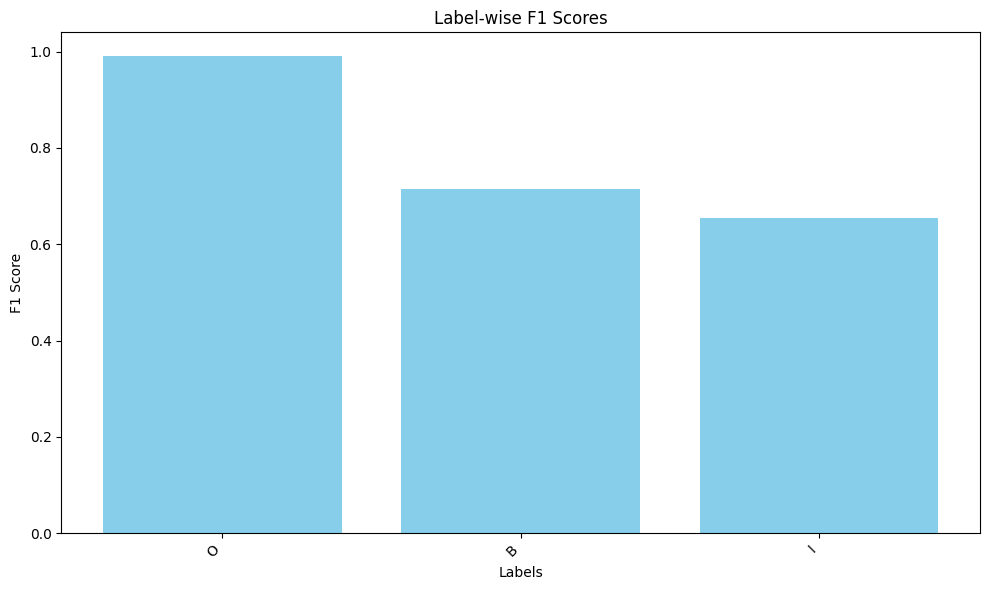

In [14]:
test_loader, test_set = get_data(2,'fasttext')
model = load_model(2,test_set.embedding,'fasttext')
results = evaluate(model, test_loader, model.loss, CRF=True)
bar(results['class_wise_f1:'])